# Predicting Resource Access Permission for Amazon Employees

In this article, we consider the [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge) hosted by Kaggle. In this challenge, we are asked to predict the resource access permissions required for a new employee given historical employee access data. This problem is motivated by the difficulties faced by new employees as they enter the company. In particular, new employees require access to resources such as web portals, printers, etc, and traditionally these access permissions are granted manually by the employee's manager, as they encounter road blocks. This process wastes a considerable amount of time for both the new employees and their manager.

The task here is to automate this process, by building models based on previously available employee access data. The models learn common access patterns required by employees based on employee attributes such as employee's role, employee's manager role, etc, and predict resources accesses required by a new employee given their attributes.

## Exploratory Data Analysis

To gain a better understanding of the data, we first conduct a exploratory data analysis. We start by loading the data into a pandas dataframe:



In [13]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Here is the first five rows of train data:

In [4]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


As we can see, train data provides us with attributes such as the resource in question, information about the role of the employee, manager id, etc, as well as the action that was granted for this employee. Here is a detailed description of the data attributes:  

|Column Name|Description|
| --- | --- |
|ACTION|ACTION is 1 if the resource was approved, 0 if the resource was not|
|RESOURCE|An ID for each resource|
|MGR_ID|The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time|
|ROLE_ROLLUP_1|Company role grouping category id 1 (e.g. US Engineering)|
|ROLE_ROLLUP_2|Company role grouping category id 2 (e.g. US Retail)|
|ROLE_DEPTNAME|Company role department description (e.g. Retail)|
|ROLE_TITLE|Company role business title description (e.g. Senior Engineering Retail Manager)|
|ROLE_FAMILY_DESC|Company role family extended description (e.g. Retail Manager, Software Engineering)|
|ROLE_FAMILY|Company role family description (e.g. Retail Manager)|
|ROLE_CODE|Company role code; this code is unique to each role (e.g. Manager)|



Test data has a similar structure, except that as expected ACTION field is not present:

In [34]:
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


First let's see if train or test data have any missing values:

In [37]:
train.isnull().sum(axis=0)

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [38]:
test.isnull().sum(axis=0)

id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

train and test data are already cleaned and there are no missing values.

Now let's get some statistics about the data:

In [39]:
train.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


ACTION field can only be 0 or 1 with about 94% of values being 1. But other fields take on a wider range of values. For example, here are 10 random samples from the RESOURCE field.

In [42]:
train.RESOURCE.sample(10)

8450     75047
25700    35376
3541     37672
13164    23921
22847     1581
16571    20281
17258    23096
9272     15818
23962    79092
28790     7543
Name: RESOURCE, dtype: int64

It seem that this field consists of categorical values which are anonymized using a label encoding. Actually the same seems to be true about all other fields. To confirm this suspicion, let find out the number of unique values for each field. 

In [50]:
import numpy as np

def f(x):
    return len(np.unique(x))
df = pd.concat([train.agg([min, max]).T, train.agg(f).to_frame()], axis=1).T
df.index = ['min', 'max', 'n_unique']
df

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
min,0,0,25,4292,23779,4674,117879,4673,3130,117880
max,1,312153,311696,311178,286791,286792,311867,311867,308574,270691
n_unique,2,7518,4243,128,177,449,343,2358,67,343



The features are anonymized, but we still can figure out their relative importance. This help us with getting better intuition about the data. To do this we first train a Random-Forest classifier on the train data. 

In [14]:
from sklearn.ensemble import RandomForestClassifier

X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
feature_importances = pd.DataFrame(clf_rf.feature_importances_.reshape(1, -1), 
                                   index=['feature_importance'], 
                                   columns=train.columns[1:])

feature_importances = feature_importances.T.sort_values(by=['feature_importance'], ascending=False).T
feature_importances

,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_ROLLUP_2,ROLE_CODE,ROLE_TITLE,ROLE_ROLLUP_1,ROLE_FAMILY
feature_importance,0.379566,0.18012,0.114294,0.102391,0.073208,0.045134,0.040788,0.034449,0.03005


In [119]:
import seaborn as sns
from matplotlib import pyplot as plt

g = sns.barplot(data=feature_importances,
            color="b")
g.set_xticklabels(feature_importances.columns, rotation=90)


[Text(0,0,u'RESOURCE'),
 Text(0,0,u'MGR_ID'),
 Text(0,0,u'ROLE_DEPTNAME'),
 Text(0,0,u'ROLE_FAMILY_DESC'),
 Text(0,0,u'ROLE_ROLLUP_2'),
 Text(0,0,u'ROLE_CODE'),
 Text(0,0,u'ROLE_TITLE'),
 Text(0,0,u'ROLE_ROLLUP_1'),
 Text(0,0,u'ROLE_FAMILY')]

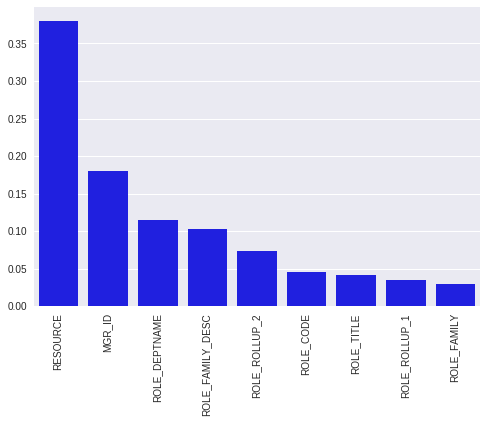

In [120]:
plt.show()

The results are somewhat expected. The resource field has the most information, followed by manager id and department.

## Training Models and Cross Validation

In the next step, we train several classifiers on the data and measure their performance using cross validation. The goal here is to get an idea about the type of performance we can get with different classifiers. So, we will use default classifier parameters and leave performance tuning for layer. 

But before we can train classifiers, we need to do some preparation. Firstly, as we observed before the data is categorical. A standard practice when dealing with categorical data is [One Hot Encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [15]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def one_hot_endcode(X_train, X_test):
    ohe = OneHotEncoder()
    X_total = np.vstack([X_train, X_test])
    X_total_ohe = ohe.fit_transform(X_total)
    n_train = X_train.shape[0]
    X_train_ohe = X_total_ohe[:n_train,]
    X_test_ohe = X_total_ohe[n_train:,]
    return X_train_ohe, X_test_ohe

X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]

X_test = test.iloc[:, 1:]
X_train_ohe, X_test_ohe = one_hot_endcode(X_train, X_test)


Secondly, we note that the performance evaluation metric for the competition is [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic):

In [24]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

def scoring(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    return roc_auc_score(y, y_pred[:, 1])
    

Given these information, we can train different classifiers and evaluate their performance. Here, we choose learning curves as performance measure for the classifiers, since they provide more intuition about the model and data.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, ax, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), fontsize=20):

    plt.title(title, fontsize=19)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.yticks(fontsize=16)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right", fontsize=16)
    plt.grid(True)
    return plt


In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

names = ["Nearest Neighbors", "Linear SVM", "Decision Tree", "Random Forest", 
         "Neural Net", "AdaBoost", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    LogisticRegression()]


In [7]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=10)
X_train_ohe_pca = pca.fit_transform(X_train_ohe)

In [11]:
plt.figure(figsize=(20, 30))
index = 1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(4, 2, index)
    index += 1
    plot_learning_curve(clf, name, ax, X_train_ohe_pca, y_train, 
                    scoring=scoring, n_jobs=3, cv=5)

plt.subplots_adjust(hspace=0.33, wspace=0.15)

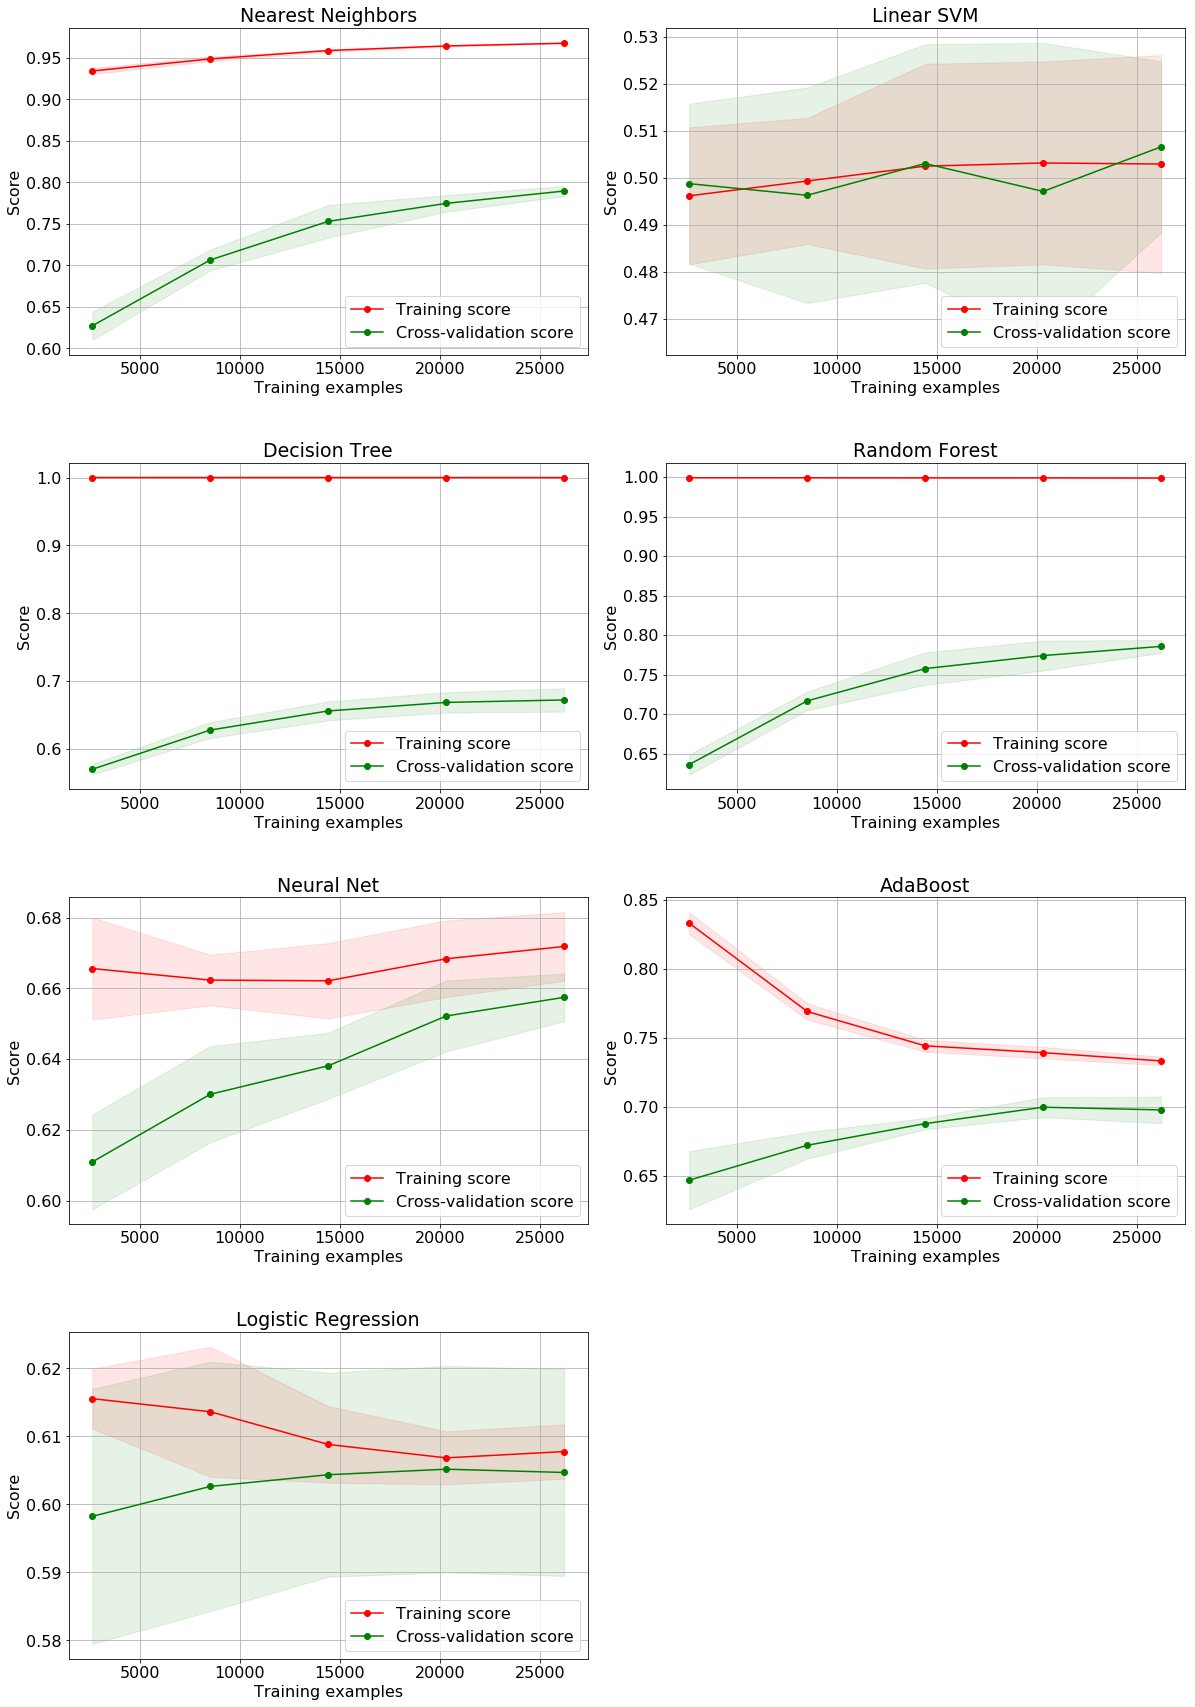

In [12]:
plt.show()

The experiment reveals that some estimators like SVM have poor performance for this data and should be avoided. Also, estimators like Random Forest and Decision Tree tend to overfit. We also learn that although Logistic Regression classifier does not have the best performance, it is the fastest among the seven classifiers we tried.

We can also calculate the cross validation score for all these classifiers. This is computationally much less intensive than obtaining the learning curves, so we don't have to use decomposition to reduce the dimensionality. 

In [26]:
scores = {}
for name, clf in zip(names, classifiers):
        score = cross_val_score(clf, X_train_ohe, y_train, n_jobs=4, scoring=scoring)
        scores[name] = score.mean()


In [33]:
pd.Series(scores).sort_values(ascending=False)

Logistic Regression    0.856455
Neural Net             0.848133
Random Forest          0.823005
Nearest Neighbors      0.812712
Linear SVM             0.747521
AdaBoost               0.725165
Decision Tree          0.699022
dtype: float64

As we see, here we get different performance picture from the learning curves and Logistic Regression provides the best performance. Let's find out if we can improve the performance of Logistic Regression classifier by optimizing the regularization parameter:

In [35]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
gs = GridSearchCV(clf, param_grid={'C': np.logspace(-1, 1, 10)}, scoring=scoring, n_jobs=4)
gs.fit(X_train_ohe, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([ 0.1    ,  0.16681,  0.27826,  0.46416,  0.77426,  1.29155,
        2.15443,  3.59381,  5.99484, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function scoring at 0x7f21786eaaa0>, verbose=0)

In [36]:
gs.best_params_

{'C': 2.1544346900318834}

In [37]:
clf = gs.best_estimator_
score = cross_val_score(clf, X_train_ohe, y_train, n_jobs=4, scoring=scoring)
score.mean()

0.8584785888043406

We get some marginal improvement over the previous result of 0.856455 which was obtained using $C = 1$.

## Feature Engineering

So far we have used each input feature individually in isolation from other features. We use feature engineering to generate new features that encode relationship among different features. For example, a particular resource may appear frequently in combination with certain manager id's or role departments.

To extract these types of relationships, we can generate new features that are a combination of all possible subsets of length k of the input features. This idea is similar in essence to generate polynomial features for numerical data. However, since here we are dealing with categorical data we need to generate feature combinations instead. The following code is a generator that produces all k-combinations of the input array s:

In [19]:
from itertools import chain
def generate_combs(s, k):
    if k == 0 or k > len(s):
        yield []
        return 
    
    for i in range(len(s)-k+1):
        for c in generate_combs(s[i+1:], k-1):
            yield [s[i]] + c

list(generate_combs(range(5), 3))

[[0, 1, 2],
 [0, 1, 3],
 [0, 1, 4],
 [0, 2, 3],
 [0, 2, 4],
 [0, 3, 4],
 [1, 2, 3],
 [1, 2, 4],
 [1, 3, 4],
 [2, 3, 4]]

We can use the above generator to compute the desired feature interactions of a given degree:

In [18]:
import numpy as np

def generate_high_order_features(data, degree=2):
    """
    Generate new features by concatinating existing features
    from data. This is similiar to polinomial feature generation
    but can be used with categorical data as well.
    
    Parameters:
    -----------
    data: numpy array, contains data with features to be concatinated
    
    degree: int, number of features to concatinate to generate each new
    feature. For example, if there are three features 'a', 'b', and 'c'
    and degree=2, generated features are 'ab', 'ac', 'bc'.
    
    """
    m, n = data.shape
    
    feature_combs = generate_combs(range(n), degree)
    
    return np.vstack(
                    [np.array([hash(tuple(row)) 
                               for row in data[:, comb].tolist()])]
                                   for comb in feature_combs
    ).T


It is much nicer to format our feature generator as a sklearn transformer. This way, we can use it in data pipelines should we need to. We call this transformer HighOrderFeatures since it produces higher order interaction of existing feature.

In [17]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin

class HighOrderFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2):
        self.degree = degree
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.as_matrix()
        elif isinstance(X, list):
            X = np.array(X)
            
        X_poli_feature = [X]
        for d in range(2, self.degree+1):
            X_poli_feature.append(generate_high_order_features(X, degree=d))

        return np.hstack(X_poli_feature)            

We instantiate a HighOrderFeature transformer with degree = 2 which means it generates features of order one (regular features) and order two (combinations of every two features). We then apply the transformer to train and test data:

In [20]:
hof = HighOrderFeatures(degree=2)
X_train_hof = hof.fit_transform(X_train)
X_test_hof = hof.fit_transform(X_test)

Unfortunately, the One-Hot-Encoder provided by sklearn has problem with processing sparse matrices, which are produced by the feature generator. So we have to write our own!

In [21]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin

class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
    
    def fit(self, X, y=None):
        col_uniques = [np.unique(c) for c in X.T]
        self.map = [dict(zip(c, range(len(c)))) for c in col_uniques]
        self.fitted = True
        return self
        
    def transform(self, X):
        if not self.fitted:
            raise Exception("Transformer not fitted.")
        
        n_samples, n_features = X.shape
        if len(self.map) != n_features:
            raise Exception("X must have the same number of columns \
                                as the matrix used to fit the transformer.")
        
        res = []
        for i, col in enumerate(X.T):
            col_indices = np.vectorize(self.map[i].get)(col)
            row_indices = np.arange(n_samples)
            ones = np.ones(n_samples)
            col_encoded = sparse.coo_matrix((ones, (row_indices, col_indices)))
            res.append(col_encoded)
            
        return sparse.hstack(res).tocsr()
            

We then apply One-Hot-Encoding to high order features generated in the previous stop:

In [22]:

def one_hot_endcode(X_train, X_test):
    ohe = OneHotEncoder()
    X_total = np.vstack([X_train, X_test])
    X_total_ohe = ohe.fit_transform(X_total)
    n_train = X_train.shape[0]
    X_train_ohe = X_total_ohe[:n_train,]
    X_test_ohe = X_total_ohe[n_train:,]
    return X_train_ohe, X_test_ohe

X_train_ohe, X_test_ohe = one_hot_endcode(X_train_hof, X_test_hof)


Finally, we are ready to train a model on our data. We use a LogisticRegression classifier similar to the previous section, to see if we have gained any performance improvement using high order features. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

clf = LogisticRegression()
gs = GridSearchCV(clf, param_grid={'C': np.logspace(-1, 1, 10)}, scoring=scoring)
gs.fit(X_train_ohe, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1    ,  0.16681,  0.27826,  0.46416,  0.77426,  1.29155,
        2.15443,  3.59381,  5.99484, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function scoring at 0x7fc53752f848>, verbose=0)

In [26]:
gs.best_params_

{'C': 0.2782559402207124}

In [27]:
clf = gs.best_estimator_
cross_val_score(clf, X_train_ohe, y_train, n_jobs=4, scoring=scoring).mean()

0.8698137523547452

The cross-validation score has improved considerably from 0.8585 to 0.8698 which is considerable improvement. Next we create a submission file using the obtain classifier and submit it to [Kaggle](https://www.kaggle.com/c/amazon-employee-access-challenge) for evaluation:

In [30]:
def make_submission_file(y_test_pred, filename=None):
    submit_data = pd.DataFrame(columns=['ID', 'ACTION'])
    submit_data['ID'] = xrange(1, len(y_test_pred)+1)
    submit_data['ACTION'] = y_test_pred
    if not filename:
        filename = 'submit.csv'
    submit_data.to_csv(filename, index=False)
    
y_test_pred = clf.predict_log_proba(X_test_ohe)[:, 1]
make_submission_file(y_test_pred, 'submit/submit.csv')

We receive scores of 0.89919 and 0.89322 on public and private leader-boards, respectively. Interestingly, the leader-board scores are higher than our own local cross-validation score which is encouraging.

The private leader-board score is used to determine the winning solution. The winning solution in this competition has the score of [0.92360](https://www.kaggle.com/c/amazon-employee-access-challenge/leaderboard). Comparing our score to this score, our score is around 97% of the winning solution which is promising. Achieving the other 3% would require employing more complex models and more extensive hyper-parameter tuning. We present some ideas how to do this in the next section. 


## Conclusions

In this article, we considered the problem of predicting access requirements for new Amazon employees. We first performed an exploratory data analysis which helped us become more familiar with the data. We also learned that all data features are categorical, which motivated the use of one-hot-encoding later when building our model. We compared the performance of several classification algorithms. We then picked Logistic-Regression due to its good performance and simplicity. We then managed to achieve a great score using feature engineering together with cross-validation and hyper-parameter tunning.

To further improve our model, we can try other classification algorithms which showed promising results in our performance comparison. In particular, as a next step we can try Random Forest and AdaBoost classifiers which offer better performance at the expense of higher complexity.  